In [ ]:
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.optimize as opt
import numpy as np
import csv
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Blakeney_project/sulfate_data_norm.csv')
df = df.loc[0:18,:]

df


,Year,Month,Depth,sulfate mM,d34s pm,hs mM
0,2020,2,0,25.601384,24.4457,NaN
1,2020,2,2,21.727414,32.4110,NaN
2,2020,2,4,18.927171,38.9113,NaN
3,2020,2,6,17.474187,41.0848,NaN
4,2020,2,8,16.764399,43.6231,NaN
5,2020,2,10,15.448003,48.1474,NaN
6,2020,2,12,14.802400,47.9057,NaN
7,2020,2,14,NaN,NaN,NaN
8,2020,2,16,14.147405,50.0300,NaN
9,2020,2,18,14.057049,50.6283,NaN


In [ ]:
def calc_diffusion(species, diffusion, space_step, time_step):
    """Diffusion time step for species through the column.
    Ignores first and last cell in the grid.
    """
    second_deriv = (species[0:-2] - 2 * species[1:-1] + species[2:]) / (space_step ** 2)
    delta_species = diffusion[1:-1] * second_deriv * time_step

    return delta_species

def calc_reaction(species, delta_rate, time_step, k_sr32, alpha):
    """Calculate all reaction rates at the start of the time step.
    Have one functions for all reactions as differing rate laws by species.
    Return reaction rate dict which can then be indexed by `specie`.
    Returned dictionary of arrays is of size `num_cells - 2` because top and bottom cells are unaffected by rate.
    """
    # Rate law
    msr32_rate = k_sr32 * species['s32o4'][1:-1]* species['labc'][1:-1]

    msr34_rate = alpha * k_sr32 * species['s34o4'][1:-1]* species['labc'][1:-1]

    # Assign signs and convert to amount by time step
    delta_rate['s32o4'] = -1 * msr32_rate * time_step
    delta_rate['h32s'] = msr32_rate * time_step
    delta_rate['s34o4'] = -1 * msr34_rate * time_step
    delta_rate['hs34'] = msr34_rate * time_step
    delta_rate['labc'] = -2 * (msr32_rate+ msr34_rate)* time_step
    return delta_rate


In [ ]:

def run_model(k_sr32, alpha,conc_labc, duration =None, initial_cond=None, array = array):
    """ This version of the model is just for calculating the profile for the first
    month of data. As there is no previous month to start from it starts from a
    totally empty column.
    :return:
    """
    # Model params
    # Isotope standards
    vcdt_32_34 = 22.6436 # per mil
    vcdt_34_32 = 1/vcdt_32_34

    # Length of cell in the x direction for a 36 cm deep column
    dz = 0.39 # cm
    num_cells = 101
    # Reaction shut off at depth where assume only diffusion is occurring
    # Assuming 20 cm for now...
    cut_off = 56 # cell number

    #Time for the model to run. In order to get the model started, this should be a
    #large number for the first month (i.e., a few years).
    #Larger time resolution will give more realistic results but take longer to run.
    max_t = 1.58e8 # s = 5 yrs
    if duration:
        max_t = duration
        #max_t = duration/4
    time_steps = int(1e5)
    dt = max_t / time_steps

    # Intialise concentration assuming an empty profile
    species_list = ['s32o4', 'h32s', 's34o4', 'h34s', 'labc','so4']
    concs = {i: np.ones(num_cells) * 1e-12 for i in species_list}

    if initial_cond:
        concs = initial_cond

    print('concs')
    # Calculate isotopologue concentrations from delta value,first month
    top_d34s  = 23 #per mil
    so4_top = 24  #
    if initial_cond==None:
      so4_top = 28
    ####!!!!s34o4_top = 24 * (top_d34s/1000+1) / vcdt_32_34
    r = (top_d34s/1000+1) * vcdt_34_32
    s34o4_top = (r/(1+r)) * so4_top
    s32o4_top = (1/(1+r)) * so4_top
    #Boundary conditions
    # Range on labc previously estimated to be between 1e-6 and 50 mM
    boundary_concs = {'s32o4':  s32o4_top,'s34o4': s34o4_top, 'h32s': 1e-12, 'h34s': 1e-12,'labc':conc_labc, 'so4':  so4_top} # mM

    #if has intitial condition, change boundary condition to the top and bottom value to read data
    #of the currect month
    if initial_cond:
      #load data to set boundary of initial conditions

        data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Blakeney_project/sulfate_data_norm.csv')
        comp  = data[data['Year']==nyear][data['Month']==nmonth]
        comp = comp.reset_index(drop=True)

    for specie in boundary_concs:
        concs[specie][0] = boundary_concs[specie]

    #clear past labc data
    if nyear == 2020 and nmonth == 7:
      concs['labc'] = np.ones(num_cells) * 1e-12

    if nyear == 2021 and nmonth == 6:
      concs['labc'] = np.ones(num_cells) * 1e-12

    # Assign isotopologue concentrations
    boundary_concs.update({'s34o4': s34o4_top})
    boundary_concs.update({'s32o4': s32o4_top})
    boundary_concs.update({'h34s': boundary_concs['h34s']})
    boundary_concs.update({'h32s': boundary_concs['h32s']})
    boundary_concs.update({'labc': boundary_concs['labc']})
    # Initialise rate profiles
    rate_names = ['s32o4', 'h32s', 's34o4', 'h34s', 'labc']
    # Chop off two cells as we don't want to change top or bottom cells
    delta_rate = {i: np.zeros(num_cells-2) for i in rate_names}


    # Calculate porosity profile
    # Exponentially decreasing porosity with depth
    #data from
    p_0 = 0.92
    gamma = 0.007 # cm-1
    porosity = p_0 * np.exp(-1 * np.arange(0, num_cells*dz, dz) * gamma)
    print(f'porosity is {porosity}')
    # DIFFUSIVITY - in units of cm2 s-1

    #create a dictionary to store diffusion coefficient for different month
    d_so4_all = {'2020-2':6.1,'2020-7':8.2,'2020-8':8.65,'2020-9':7.8,'2020-10':7.0,'2020-11':6.5,'2020-12':5.7,
                 '2021-2':5.7,'2021-3':6.2,'2021-4':6.0,'2021-5':6.9,'2021-6':8.1,'2021-7':8.4,'2021-8':2,
                 '2021-9':8.2,'2021-10':7.2}

    d_0 = {
        's34o4': d_so4_all[f'{nyear}-{nmonth}']*1e-6,
        'h34s': 7e-6,
        'labc': 2e-6, #need to change the diffusivity of labile carbon
    }

    # Correct diffusion coefficients for porosity
    d_mod = {i: d_0[i] / (1 + 3 * (1 - porosity)) for i in d_0.keys()} #using iversen and jorgensen

    d_mod.update({'s32o4': d_mod['s34o4']})
    d_mod.update({'h32s': d_mod['h34s']})


    # Model loop
    for i in range(time_steps):
        # Calculate rates at this time step.

        delta_rate = calc_reaction(concs, delta_rate, dt, k_sr32, alpha)

        for specie in concs:
            #previous month of specie contains 'so4', skip calculating diffusion so4
            if specie == 'so4':
              continue;
            species = concs[specie]
            delta_diffusion = calc_diffusion(species, d_mod[specie], dz, dt)

            if specie == 'labc':
              species[1:-1] = species[1:-1] + delta_diffusion + delta_rate[specie]

            else:
              species[1:-1] = species[1:-1] + delta_diffusion + delta_rate[specie]

            # Top boundary remains the same by construction
            # Have flow boundary condition at bottom i.e d[X]/dz = 0
            species[-1] = species[-2]

            # Apply boundary conditions for the bottom, assuming the bottom sulfate is 16.5 for all the month
            if specie == 's32o4':
                species[0] = boundary_concs['s32o4']
                r_bot = ((df['d34s pm'][18] /1000)+1)*vcdt_34_32
                species[-1] = 16.5*(1/(1+r_bot))

            if specie == 's34o4':
                species[0] = boundary_concs['s34o4']

                r_bot = ((df['d34s pm'][18] /1000)+1)*vcdt_34_32
                species[-1] = 16.5*(r_bot/(1+r_bot))

            if specie == 'labc':
                species[0] = boundary_concs['labc']


            # Values can't go negative
            mask = species > 1e-30

            species = species * (np.ones(len(species)) * mask) + 1e-30

            concs.update({specie: species})
    #convert everything back to so4,d34S, and total k
    concs.update({'so4': np.ones(num_cells) * 1e-12 })
    concs.update({'so4': concs['s34o4']+concs['s32o4']})
    # calculate d34S based on the modelled conc output_Bizhou
    d34S = (((concs['s34o4']/concs['s32o4'])/vcdt_34_32)-1)*1000
    k_sr = np.ones(num_cells) * 1e-12
    k_sr = (k_sr32*concs['s32o4']+k_sr32*alpha*concs['s34o4'])/concs['so4']
    print(concs)
    return concs, delta_rate, d34S, k_sr,k_sr32, alpha

In [ ]:
#fisrt month cell
%%time
nyear = 2020
nmonth = 2
concs, delta_rate, d34S,k_sr,k_sr32_1, alpha= run_model(0.035e-8, 0.95,200)
concs2, delta_rate2,d34S2,k_sr2,k_sr32_2, alpha2 = run_model(0.03e-8, 0.95,200)
concs3, delta_rate3,d34S3,k_sr3,k_sr32_3, alpha3 = run_model(0.04e-8, 0.95,200)

concs
porosity is [0.92       0.91749183 0.91499049 0.91249597 0.91000825 0.90752732
 0.90505315 0.90258572 0.90012502 0.89767103 0.89522373 0.89278311
 0.89034913 0.88792179 0.88550107 0.88308695 0.88067941 0.87827844
 0.87588401 0.8734961  0.87111471 0.86873981 0.86637139 0.86400942
 0.86165389 0.85930478 0.85696208 0.85462576 0.85229582 0.84997222
 0.84765496 0.84534402 0.84303938 0.84074102 0.83844893 0.83616308
 0.83388347 0.83161007 0.82934287 0.82708186 0.824827   0.8225783
 0.82033572 0.81809926 0.81586889 0.81364461 0.81142639 0.80921421
 0.80700807 0.80480794 0.80261381 0.80042567 0.79824349 0.79606725
 0.79389695 0.79173257 0.78957409 0.78742149 0.78527476 0.78313388
 0.78099884 0.77886963 0.77674621 0.77462859 0.77251673 0.77041064
 0.76831029 0.76621566 0.76412674 0.76204352 0.75996598 0.7578941
 0.75582787 0.75376728 0.7517123  0.74966292 0.74761913 0.74558092
 0.74354826 0.74152114 0.73949955 0.73748347 0.73547288 0.73346778
 0.73146814 0.72947396 0.72748521 0.72550188 0

In [ ]:
#Save the first month model results to csv
concs_data = pd.DataFrame.from_dict(concs2)
concs_data['d34S'] = d34S2
concs_data.to_csv(f'concs_{2020}_{2}_OM_norm_k32.csv')
files.download(f'concs_{2020}_{2}_OM_norm_k32.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#run model later month, set up months, year, time in model and load original data
#manually chose the month to run

#Previous month:
pyear = 2020
pmonth = 7
#Next month:
nyear = 2020
nmonth = 8

#now input the duration of time from previous month to the current month
time = ((nyear*12+nmonth)-(pyear*12+pmonth))*30*24*60*60 # now convert month to seconds
#load the saved csv results as dataframe, and then convert to dict, in case old files have been overwritten
#at some piont

pconcs_csv = pd.read_csv(f'concs_{pyear}_{pmonth}_OM_norm_k32.csv')
pconcs = pconcs_csv.to_dict(orient='list')
pconcs.pop('Unnamed: 0')
pconcs.pop('d34S')

#dict_with_lists = df.to_dict(orient='list')
pconcs_numpy = {key: np.array(value) for key, value in pconcs.items()}
print(f'previous month is {pconcs_numpy}')

concs, delta_rate, d34S, k_sr,k_sr32_1, alpha= run_model(40e-8, 0.96, conc_labc= 200,duration = time,initial_cond=pconcs_numpy)
pconcs_numpy = {key: np.array(value) for key, value in pconcs.items()}




previous month is {'s32o4': array([22.96258863, 16.88250609, 13.0559986 , 10.53902967,  8.83585548,
        7.66663952,  6.86387031,  6.3221769 ,  5.97232568,  5.76699072,
        5.67261346,  5.66457555,  5.72425202,  5.83716871,  5.99182547,
        6.17892846,  6.39087707,  6.62141053,  6.86535523,  7.11843639,
        7.3771312 ,  7.63854996,  7.90033683,  8.16058536,  8.417766  ,
        8.67066368,  8.91832432,  9.16000935,  9.39515731,  9.62335181,
        9.84429506, 10.05778617, 10.26370354, 10.46199063, 10.65264458,
       10.83570708, 11.01125712, 11.17940507, 11.340288  , 11.49406585,
       11.64091818, 11.78104153, 11.91464709, 12.04195865, 12.16321083,
       12.27864734, 12.38851951, 12.49308481, 12.59260543, 12.68734705,
       12.77757753, 12.86356572, 12.9455803 , 13.02388872, 13.09875612,
       13.17044436, 13.23921107, 13.30530881, 13.36898424, 13.43047739,
       13.49002096, 13.54783969, 13.60414986, 13.65915875, 13.71306426,
       13.76605452, 13.8183076 , 13.

<ipython-input-49-959767bce49a>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp  = data[data['Year']==nyear][data['Month']==nmonth]


KeyError: 'k'

In [ ]:
#save the best fit modelled profile
concs_data = pd.DataFrame.from_dict(concs)
rate_data = pd.DataFrame.from_dict(delta_rate)
concs_data['d34S'] = d34S
concs_data.to_csv(f'concs_{nyear}_{nmonth}_OM_norm_k32.csv')
files.download(f'concs_{nyear}_{nmonth}_OM_norm_k32.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-67-85d85bbd151a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comp  = data[data['Year']== nyear][data['Month']==nmonth]


"\n#This section modeled the isotope profile\nax[2].plot(concs['s34o4'], np.arange(len(concs['so4'])) * 0.4)\nax[2].plot(concs2['s34o4'], np.arange(len(concs['so4'])) * 0.4)\nax[2].plot(concs3['s34o4'], np.arange(len(concs['so4'])) * 0.4)\nax[2].plot(concs4['s34o4'], np.arange(len(concs['so4'])) * 0.4)\nax[2].invert_yaxis()\nax[2].xaxis.set_label_position('top')\nax[2].xaxis.tick_top()\n#This section imports the in-situ data for the isotope data\n#ax[1].scatter(df['d34s pm'], df['Depth'])\nax[2].set_xlabel('s34o4 (mM)', size = 12)\nax[3].plot(concs['s32o4'], np.arange(len(concs['so4'])) * 0.4)\nax[3].plot(concs2['s32o4'], np.arange(len(concs['so4'])) * 0.4)\nax[3].plot(concs3['s32o4'], np.arange(len(concs['so4'])) * 0.4)\nax[3].plot(concs4['s32o4'], np.arange(len(concs['so4'])) * 0.4)\nax[3].invert_yaxis()\nax[3].xaxis.set_label_position('top')\nax[3].xaxis.tick_top()\n#This section imports the in-situ data for the isotope data\n#ax[1].scatter(df['d34s pm'], df['Depth'])\nax[3].set_xla

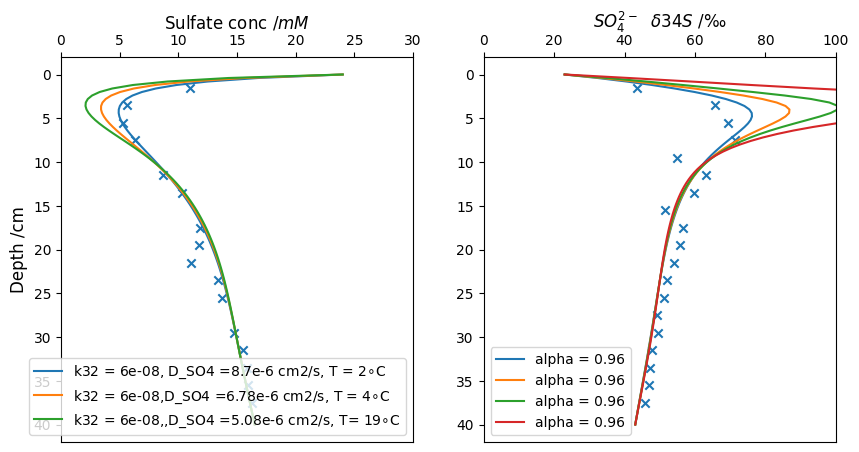

In [ ]:
#plot data and fit curves

from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Blakeney_project/sulfate_data_norm.csv')
import matplotlib as mpl
from matplotlib import pyplot as plt

comp  = data[data['Year']== nyear][data['Month']==nmonth]
comp = comp.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,5), ncols = 2)
#this plot the modeled concentration profile
comp['Depth'] = comp['Depth'] +1.5
ax[0].plot(concs['so4'], np.arange(len(concs['so4'])) * 0.40,label=f'k32 = {k_sr32_1}'
      )
ax[0].plot(concs2['so4'], np.arange(len(concs2['so4'])) * 0.40,label=f'k32 = {k_sr32_2}'
     )
ax[0].plot(concs3['so4'], np.arange(len(concs3['so4'])) * 0.4,label=f'k32 = {k_sr32_3}'
      )
ax[0].plot(concs4['so4'], np.arange(len(concs4['so4'])) * 0.4,label=f'k32 = {k_sr32_4}')
ax[0].set_xlim(0, 30)
ax[0].set_ylabel('Depth /cm',size =12)
ax[0].set_xlabel('Sulfate conc /$mM$',size =12)
ax[0].invert_yaxis()
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.tick_top()

#This section imports the in-situ data for the sulfide-rich ponds
ax[0].scatter(comp['sulfate mM'], comp['Depth'],marker = 'x')
ax[0].legend(loc = 'lower right')

#This section modeled the isotope profile
ax[1].plot(d34S, np.arange(len(concs['so4'])) * 0.4,label=f'alpha = {alpha}')
ax[1].plot(d34S2, np.arange(len(concs2['so4'])) * 0.4,label=f'alpha = {alpha2}')
ax[1].plot(d34S3, np.arange(len(concs3['so4'])) * 0.4,label=f'alpha = {alpha3}')
ax[1].plot(d34S4, np.arange(len(concs4['so4'])) * 0.4,label=f'alpha = {alpha4}')
ax[1].set_xlim(0, 100)
ax[1].invert_yaxis()
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.tick_top()
#ax[1].set_ylabel('Depth /cm', size = 12)
ax[1].set_xlabel('$SO^{2-}_4$  $\delta 34S$ /$\perthousand$', size = 12)
#This section imports the in-situ data for the isotope data
ax[1].scatter(comp['d34s pm'], comp['Depth'],marker = 'x')
ax[1].legend(loc = 'lower left')

#This section modeled the isotope profile
ax[2].plot(concs['s34o4'], np.arange(len(concs['so4'])) * 0.4)
ax[2].plot(concs2['s34o4'], np.arange(len(concs['so4'])) * 0.4)
ax[2].plot(concs3['s34o4'], np.arange(len(concs['so4'])) * 0.4)
ax[2].plot(concs4['s34o4'], np.arange(len(concs['so4'])) * 0.4)
ax[2].invert_yaxis()
ax[2].xaxis.set_label_position('top')
ax[2].xaxis.tick_top()
#This section imports the in-situ data for the isotope data
#ax[1].scatter(df['d34s pm'], df['Depth'])
ax[2].set_xlabel('s34o4 (mM)', size = 12)
ax[3].plot(concs['s32o4'], np.arange(len(concs['so4'])) * 0.4)
ax[3].plot(concs2['s32o4'], np.arange(len(concs['so4'])) * 0.4)
ax[3].plot(concs3['s32o4'], np.arange(len(concs['so4'])) * 0.4)
ax[3].plot(concs4['s32o4'], np.arange(len(concs['so4'])) * 0.4)
ax[3].invert_yaxis()
ax[3].xaxis.set_label_position('top')
ax[3].xaxis.tick_top()
#This section imports the in-situ data for the isotope data
#ax[1].scatter(df['d34s pm'], df['Depth'])
ax[3].set_xlabel('s32o4 (mM)', size = 12)
lab1 = str(concs['labc'][0])
lab2 = str(concs2['labc'][0])
lab3 = str(concs3['labc'][0])
lab4 = str(concs4['labc'][0])
ax[4].plot(concs['h32s'], np.arange(len(concs['so4'])) * 0.4,label=f'{nyear}-{nmonth}')
ax[4].plot(concs2['h32s'], np.arange(len(concs['so4'])) * 0.4)
ax[4].plot(concs3['h32s'], np.arange(len(concs['so4'])) * 0.4)
ax[4].plot(concs4['h32s'], np.arange(len(concs['so4'])) * 0.4)
ax[4].legend(loc = 'upper right')
ax[4].invert_yaxis()
ax[4].set_xlim(0, 40)
ax[4].xaxis.set_label_position('top')
ax[4].xaxis.tick_top()
ax[4].set_xlabel('HS- (mM)', size = 12, )

ax[5].plot(concs['labc'], np.arange(len(concs['labc'])) * 0.4, label=f'labc = {lab1}')
ax[5].plot(concs2['labc'], np.arange(len(concs['labc'])) * 0.4,label=f'labc = {lab2}')
ax[5].plot(concs3['labc'], np.arange(len(concs['labc'])) * 0.4,label=f'labc = {lab3}')
ax[5].plot(concs4['labc'], np.arange(len(concs['labc'])) * 0.4,label=f'labc = {lab4}')
ax[5].legend(loc = 'lower left')
ax[5].invert_yaxis()
ax[5].xaxis.set_label_position('top')
ax[5].xaxis.tick_top()
ax[5].set_xlabel('labc (mM)', size = 12)

ax[6].plot(k_sr, np.arange(len(concs['so4'])) * 0.4,label=f'k = {np.round(np.average(k_sr),decimals=9)}')
ax[6].plot(k_sr2, np.arange(len(concs['so4'])) * 0.4,label=f'k = {np.round(np.average(k_sr2),decimals=9)}')
ax[6].plot(k_sr3, np.arange(len(concs['so4'])) * 0.4,label=f'k = {np.round(np.average(k_sr3),decimals=9)}')
ax[6].plot(k_sr4, np.arange(len(concs['so4'])) * 0.4,label=f'k = {np.round(np.average(k_sr4),decimals=9)}')
ax[6].invert_yaxis()
ax[6].xaxis.set_label_position('top')
ax[6].xaxis.tick_top()
ax[6].set_xlabel('k(mM/s)', size = 12)
ax[6].legend(loc = 'lower left')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
$4 \times 10^{-8}  s^{-1}$
-


<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Year']== y][results['Month']== m]
<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Year']== y][results['Month']== m]
<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Year']== y][results['Month']== m]
<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Year']== y][results['Month']== m]
<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Year']== y][results['Month']== m]
<ipython-input-15-7bac5b6a635d>:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = results[results['Ye

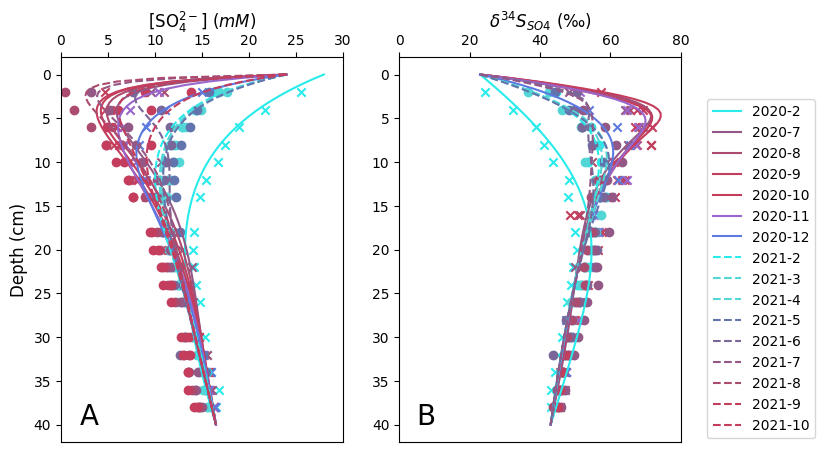

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')
fig, ax = plt.subplots(figsize=(8,5), ncols = 2)
#plot a figure including all the original SO4+d34S and all modelled SO4_d34S
date = {2020:[2,7,8,9,10,11,12], 2021:[2,3,4,5,6,7,8,9,10]}

k_value= {"k":[r'- ',r'$4 \times 10^{-8}  s^{-1}$',r'$6 \times 10^{-8} s^{-1}$',r'$6 \times 10^{-8} s^{-1}$',r'$5 \times 10^{-8} s^{-1}$',r'$1.5 \times 10^{-8} s^{-1}$',
               r'$0.3 \times 10^{-8} s^{-1}$',r'$0.15 \times 10^{-8} s^{-1}$',r'$0.15 \times 10^{-8} s^{-1}$',r'$0.15 \times 10^{-8} s^{-1}$',
               r'$0.15 \times 10^{-8} s^{-1}$',r'$6.5 \times 10^{-8} s^{-1}$',r'$25 \times 10^{-8} s^{-1}$',r'$40 \times 10^{-8} s^{-1}$',
               r'$5 \times 10^{-8} s^{-1}$',r'$0.5 \times 10^{-8} s^{-1}$']}

#unit is e-8/mM/s
alpha = {"a":['-', '0.96', '0.965','0.965','0.97','0.95','0.935','0.93','0.93','0.935','0.935','0.975','0.985','-','-','-']}
print(k_value["k"][1])
print(alpha["a"][0])

i = 0
j = 0

###Here read file to import measured
results = pd.read_csv('sulfate_data_norm_2.csv')
#access key and values in a dictionary
for y in date:
  for m in date[y]:

      j = j+1 #indexing k and alpha value
      if i >=12: #indexing for color code
        i = i-12
      a = 0.08*(m-1)
      b = 1-0.08*(m-1)
      if 0 < m & m < 4:
        col = (a*2, b, b)

      if 4 < m & m < 10:
        col = (a*1.2, b/1.5, b)

      if m > 10:
        col = (b*3, a-0.4, a)

      model = pd.read_csv(f'concs_{y}_{m}_OM_norm.csv')
      data = results[results['Year']== y][results['Month']== m]
      data = data.reset_index(drop=True)

      model_depth = model.index * 0.4
      model_SO4 = np.asarray(model['so4'], dtype=float)
      model_d34S = np.asarray(model['d34S'], dtype=float)

      data_depth = data['Depth']
      data_SO4 = data['sulfate mM']
      data_d34S = data['d34s pm']

      k = k_value["k"][j-1]


      alph = alpha["a"][j-1]
      if y == 2020:
        marker_s = 'x'
        line = '-'
      if y == 2021:
        marker_s = 'o'
        line = '--'
      ax[0].plot(model_SO4, model_depth,color=col, ls = line)
      ax[0].scatter(data_SO4,data_depth+2,marker =marker_s,color=col)
      if y == 2021:
         if 7< m <=10: #skip the month without isotope values
            model_d34S = np.linspace(-1,-2,num=101)

      ax[1].plot(model_d34S, model_depth, color=col, label = f'{y}-{m}', ls = line)
      ax[1].scatter(data_d34S,data_depth+2,marker = marker_s, color=col)

ax[0].set_xlim(0, 30)
ax[0].set_ylabel('Depth (cm)',size =12)
ax[0].set_xlabel('[SO$_{4}^{2-}$] ($mM$)',size =12)
ax[0].invert_yaxis()
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.tick_top()
ax[0].text(2, 40,'A',size =20)
ax[1].text(5, 40,'B',size =20)

#plt.legend(bbox_to_anchor=(0.1, 1.02, 1., .102), loc='upper right')
ax[1].set_xlim(0, 80)

ax[1].set_xlabel('$\delta^{34}S_{SO4}$ ($\perthousand$)',size =12)
ax[1].invert_yaxis()
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.tick_top()

plt.legend(bbox_to_anchor=(0.3, 0, 1.2,0.9), loc='center right')
resolution_value = 1200
plt.savefig("Model_fit_final.pdf", format="pdf", dpi=resolution_value, bbox_inches='tight')